In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def Initialize(particle_per_cell, node_num, domain_height, dt, simulation_time,randomParticle):
    particle_num = (node_num - 1) * (particle_per_cell - 1) + 1   # Number of particles in 'y' dimension # 1D
    dx = domain_height / (node_num - 1)  # Node spacing
    dp = domain_height / (particle_num - 1)  # Particle spacing
    xI = np.arange(0, domain_height + dx, dx)  # Node locations
    # xp = np.arange(0, domain_height + dp, dp)  # Particle locations
    if randomParticle:
        np.random.seed(0)  # Set random seed for reproducibility
        xp = np.linspace(0, domain_height, particle_num)
        randomVector = dp * (np.random.rand(len(xp) - 2) - 0.5)
        xp[1:-1] += randomVector
    else:
        xp = np.linspace(0, domain_height, particle_num)  # Particle locations
    uI = np.zeros(len(xI))  # Node displacement
    pI = np.zeros(len(xI))  # Node pressure
    time_step_num = int(simulation_time / dt)  # Total number of time steps

    # Calculate particle volumes
    midpoint = (xp[1:] - xp[:-1]) / 2 + xp[:-1]
    vp = np.concatenate(([midpoint[0]], midpoint[1:] - midpoint[:-1], [domain_height - midpoint[-1]]))

    # Initialize normal vector at y = 0 (Dirichlet BC)
    n = np.zeros(particle_num)
    n[0] = -1

    return particle_num, dx, dp, xp, vp, xI, uI, pI, n, time_step_num


In [8]:
def GetRK(xI, dx, xp, supportNorm): # Node location, Node spacing, Particle location, Normalized RK approximation support size
    nodeNum = len(xI)                   # Number of background grid nodes
    particleNum = len(xp)               # Number of locations to evaluate the RK shape functions at
    w = np.zeros((nodeNum, particleNum))  # Initialize vector for kernel function weights
    phi = np.zeros((nodeNum, particleNum))  # Initialize vector for RK shape functions
    dphi = np.zeros((nodeNum, particleNum))  # Initialize vector for RK shape function gradient
    support = supportNorm * dx           # Define support size for this discretization
    support0 = support                   # "Initial" support size, only necessary if it will be changed

    for idx in range(particleNum):
        M = np.zeros((2, 2))                     # Initialize moment matrix
        for I in range(nodeNum):
            z = abs(xp[idx] - xI[I]) / support  # Normalized distance between the particle to each node

            if 0 <= z and z <= 0.5:  # Define cubic b-spline kernel function weights
                w[I, idx] = 2/3 - 4*z**2 + 4*z**3
            elif 0.5 <= z and z < 1:
                w[I, idx] = 4/3 - 4*z + 4*z**2 - (4/3)*z**3
            else:
                w[I, idx] = 0

            # if 0 <= z and z <= 1:  # Define tent b-spline kernel function weights
            #     w[I, idx] = 1 - z
            # else:
            #     w[I, idx] = 0

            PxI = np.array([1, xI[I] - xp[idx]])  # Define P(xI - xp)
            if w[I, idx] != 0:  # If the kernel function weight is not zero
                M = M + w[I, idx] * np.outer(PxI, PxI)  # Define the moment matrix
        for J in range(nodeNum):  # Define RK approximation
            PxI = np.array([1, xI[J] - xp[idx]])
            Ploc = np.array([1, 0])
            PlocGrad = np.array([0, 1])
            phi[J, idx] = w[J, idx] * np.dot(Ploc, np.linalg.solve(M, PxI))
            dphi[J, idx] = w[J, idx] * np.dot(PlocGrad, np.linalg.solve(M, PxI))

    return phi, dphi

In [9]:
def B_spline(xI,xp):
    nodeNum = len(xI)                   # Number of background grid nodes
    particleNum = len(xp)               # Number of locations to evaluate the RK shape functions at
    w = np.zeros((nodeNum, particleNum))  # Initialize vector for kernel function weights
    dw = np.zeros((nodeNum, particleNum))  # Initialize vector for kernel function weights

    for idx in range(particleNum):
        for I in range(nodeNum):
            z = abs(xp[idx] - xI[I])  # Normalized distance between the particle to each node

            if 0 <= z and z <= 0.5:  # Define cubic b-spline kernel function weights
                w[I, idx] = 2/3 - 4*z**2 + 4*z**3
            elif 0.5 <= z and z < 1:
                w[I, idx] = 4/3 - 4*z + 4*z**2 - (4/3)*z**3
            else:
                w[I, idx] = 0

            # if 0 <= z and z <= 1:  # Define tent b-spline kernel function weights
            #     w[I, idx] = 1 - z
            #     dw[I, idx] = -1
            # else:
            #     w[I, idx] = 0
            #     dw[I, idx] = 0

    return w, dw

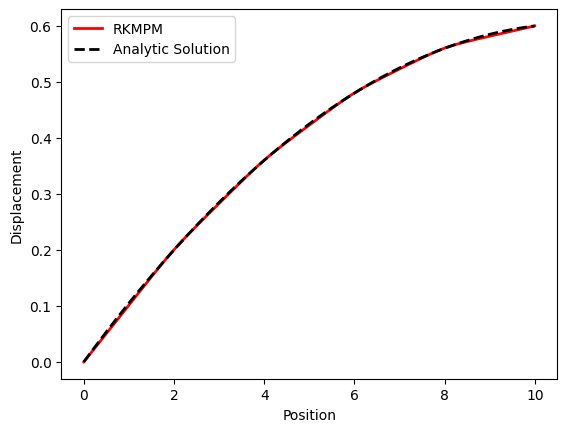

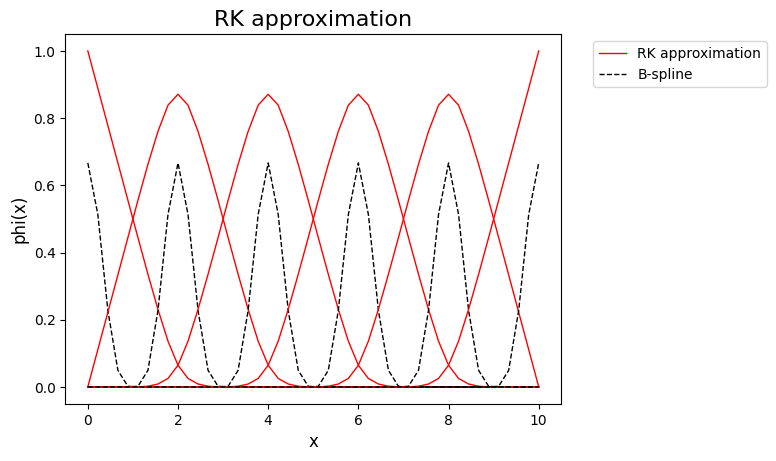

In [14]:
# 初始化參數
E = 1e3
nu = 0
rho = 1
nodeNum = 6
particlePerCell = 10
domainHeight = 10
dt = 1
simulationTime = 1
betaNorm = 1000
supportNorm = 1.5
g = 1e1
traction = 1e1
dirichletBC = 0
tractionBC = domainHeight
randomParticle = False

# 初始化變數
particleNum, dx, dp, xp, vp, xI, uI, pI, n, timeStepNum = Initialize(particlePerCell, nodeNum, domainHeight, dt, simulationTime,randomParticle)
uI2 = np.copy(uI)
beta = betaNorm * E / dx # Define Nitsche's method penalty parameter

for t in range(timeStepNum):
    Kuu = np.zeros((nodeNum, nodeNum))
    F = np.zeros(nodeNum)
    Kuu_B = np.zeros((nodeNum, nodeNum))
    F_B = np.zeros(nodeNum)
    phi,dphi=GetRK(xI,dx,xp,supportNorm)
    w,dw = B_spline(xI,xp)

    for p in range(particleNum):
        Kuu += E * np.outer(dphi[:, p], dphi[:, p]) * vp[p]
        F += phi[:, p] * rho * g * vp[p]
        Kuu_B += E * np.outer(dw[:, p], dw[:, p]) * vp[p]
        F_B += w[:, p] * rho * g * vp[p]

        if xp[p] == dirichletBC:
            Nitsche_term = beta * np.outer(phi[:, p], phi[:, p]) * 1 - E * np.outer(dphi[:, p], phi[:, p]) * n[p] * 1 - E * np.outer(phi[:, p], dphi[:, p]) * n[p] * 1
            Kuu += Nitsche_term
        elif xp[p] == tractionBC:
            F += phi[:, p] * traction * 1

        # if xp[p] == dirichletBC:
        #     Nitsche_term = beta * np.outer(w[:, p], phi[:, p]) * 1 - E * np.outer(dw[:, p], w[:, p]) * n[p] * 1 - E * np.outer(w[:, p], dw[:, p]) * n[p] * 1
        #     Kuu_B += Nitsche_term
        # elif xp[p] == tractionBC:
        #     F_B += w[:, p] * traction * 1

    uI = np.linalg.solve(Kuu, F)
    # uI_2 = np.linalg.solve(Kuu_B, F_B)

    # 計算解析解
    # x = sp.symbols('x')
    # uA = sp.Function('uA')(x)
    # # print(uA)
    # DE = E * uA.diff(x,x) + rho * g
    # print(DE)
    # du = sp.diff(uA,x)
    # print(du)
    # BC = [du.subs(x, domainHeight) - traction / E, uA.subs(x, 0) - 0]
    # print(BC[0])
    # print(BC[1])
    # print(uA)
    # uA = sp.dsolve(DE, uA, ics={uA(0):0,du.subs(x,domainHeight):(traction / E)})
    # # print(uA)
    # uAPlot = [uA.subs(x, xi) for xi in xI]

    # 計算解析解
    x_exact=np.arange(0,10,0.001)
    f=-0.005*x_exact**2+0.11*x_exact
    phiU, dphiU = GetRK(xI,dx,x_exact,supportNorm)
    wU,_ = B_spline(xI,x_exact)
    uc = np.dot(uI,phiU)
    # uc2 = np.dot(uI_2,wU)

    # 繪圖
    plt.figure(1)
    plt.plot(x_exact, uc, 'r-', linewidth=2, label='RKMPM')
    # plt.plot(x_exact, uc2, 'g-', linewidth=2, label='B-Spline MPM')
    plt.plot(x_exact, f, 'k--', linewidth=2, label='Analytic Solution')
    plt.xlabel('Position')
    plt.ylabel('Displacement')
    plt.legend()

    plt.figure(2)
    for I in range(nodeNum):
        plt.plot(xp,phi[I,:],'r-',lw=1)
        plt.plot(xp,w[I,:],'k--',lw=1)
    plt.xlabel('x',fontsize=12)
    plt.ylabel('phi(x)',fontsize=12)
    plt.title('RK approximation',fontsize=16)
    plt.legend(['RK approximation','B-spline'],bbox_to_anchor=(1.05, 1),loc=2)

    plt.show()